# Segmentation
to solve segmentation problem with thresholding tecnhique i used Otsu method (link) for finding the best threshold separately for each image,this threshold was calculate on part of the image delimited by the o-contour, this method gives mean IOU of 0.7269,
also filling the holes in i-contours might improve result. 
to further improve the result i used morphological closing (smth follower by something) using elliptical kernel with size 6x6 which gave mean IOU of 0.7608. Size found by trying out different sizes from 3x3 to 16x16 and selecting one giving the best IOU (in general casee hyperparameters must be tuned on validation dataset to not overfit to training data, but for simplicity and without well defined validation and test sets I skipped this).




also information returned from `dicom..... ` looks like it might helpful to get additional insight into data, but incorporating this information might require additional domain knowledge .

Also I notices that some samples are incorrectly labeles as i-contours not always contained within o-contours


to evaluate perormance I used mean IOU calculated on all samples




In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from hyperopt import fmin, hp, tpe
from data_loader import DataLoader
from models import OtsuThresholding

%matplotlib inline
plt.rcParams['figure.figsize'] = (8, 8)

# Load data

In [2]:
# load all samples in one batch
data_loader = DataLoader(path='./test/fixtures/final_data', batch_size=100, seed=42)

In [3]:
images, i_contours, o_contours = list(data_loader)[0]
# area betweeen i-contour and o-contour
between = (o_contours.astype(np.float32) - i_contours.astype(np.float32)).clip(0, 1).astype(np.bool)

# Search for hyperparameters
There is no need for using hyperparameter optimization library for such simple case, but I decided to leave it here just as an example

In [8]:
def objective(params):
    model = OtsuThresholding(kernel_size=int(round(params['kernel_size'])))
    iou = model.score((images, o_contours), i_contours)
    return -iou
    
hparams_space = {
    'kernel_size': hp.uniform('kernel_size', 3, 17)
}

hparams = fmin(objective, space=hparams_space, algo=tpe.suggest, max_evals=100)
hparams['kernel_size'] = int(round(hparams['kernel_size']))
print('hparams: {}'.format(hparams))

model = OtsuThresholding(kernel_size=hparams['kernel_size'])
iou = model.score((images, o_contours), i_contours)
print('mean iou: {:.4f}'.format(iou))

hparams: {'kernel_size': 6}
mean iou: 0.7608


# Predict i-contours

In [5]:
i_contours_pred = model.predict((images, o_contours))

# Visualizing predictions

not correctly labeled or shifted

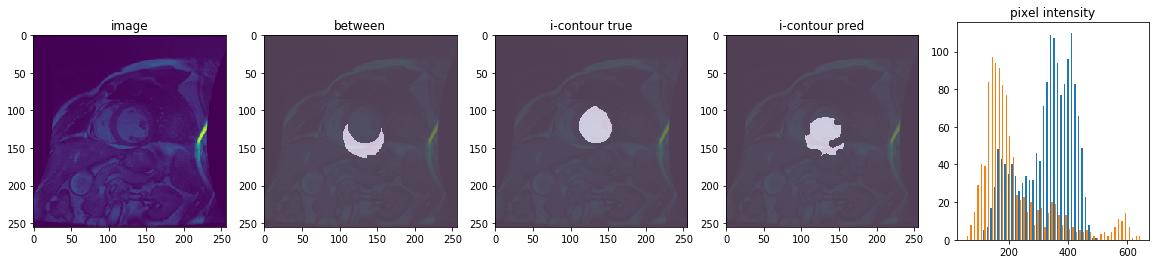

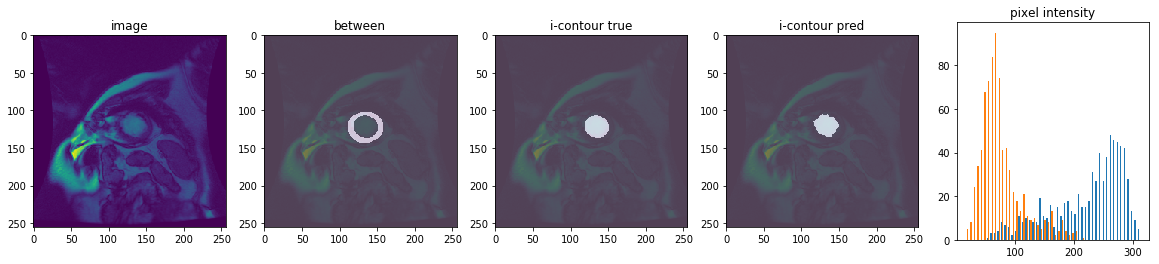

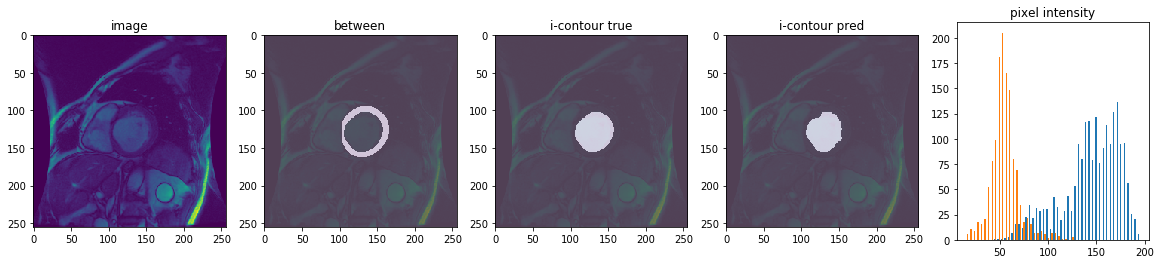

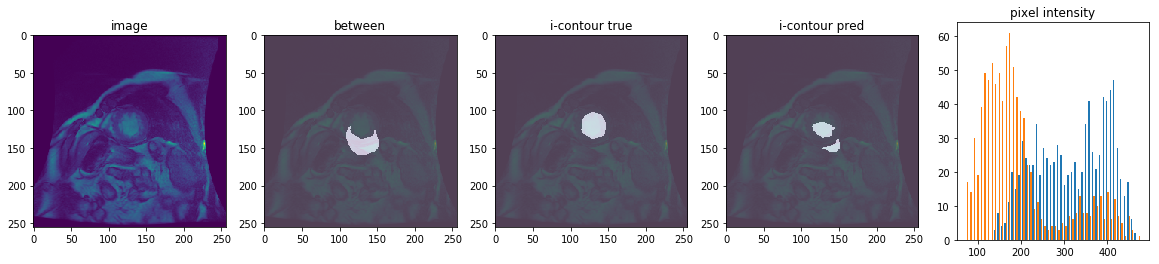

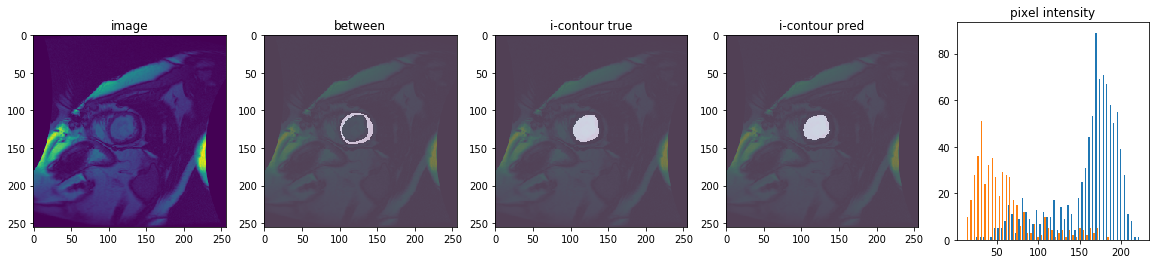

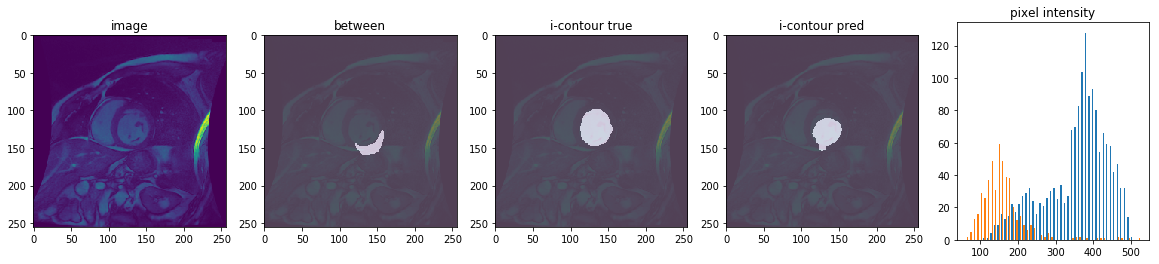

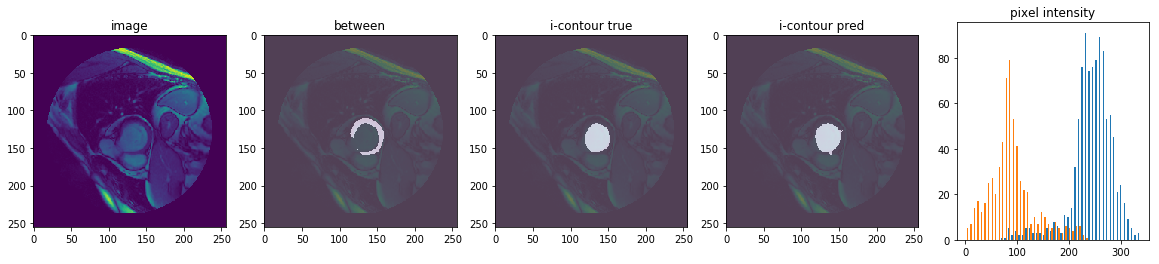

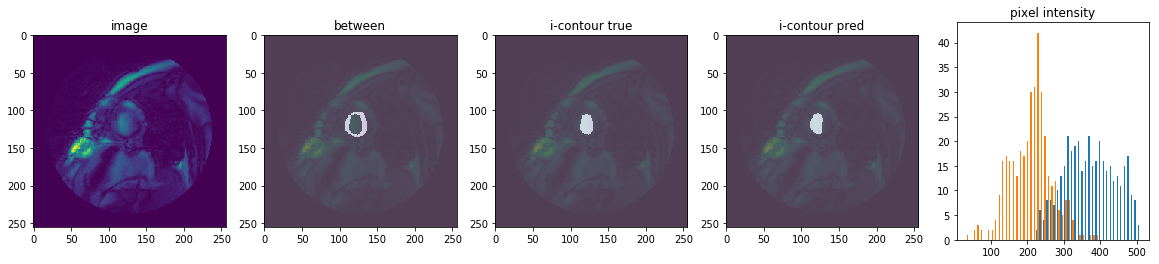

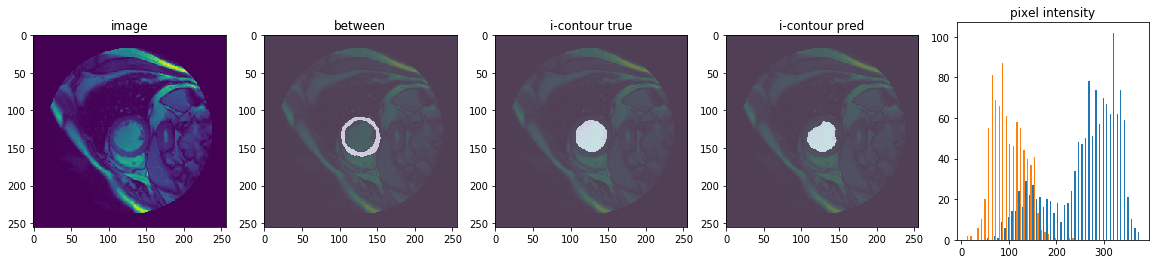

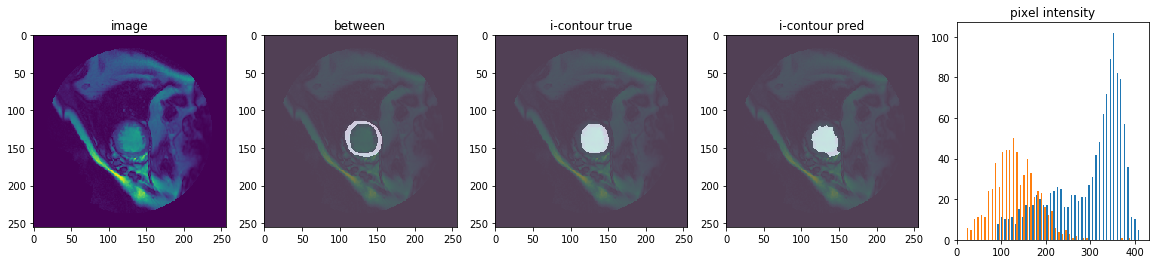

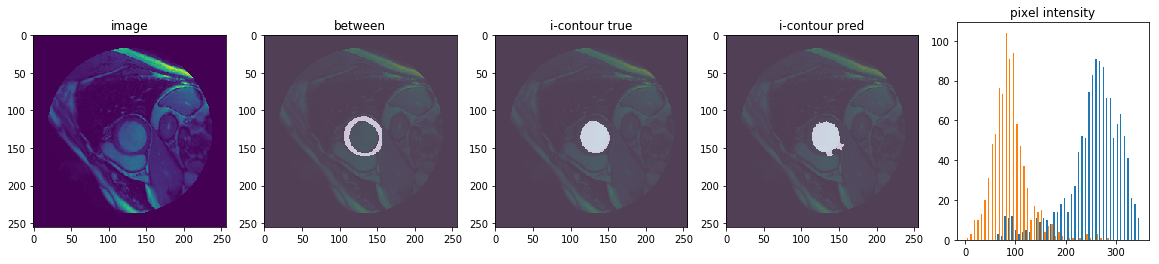

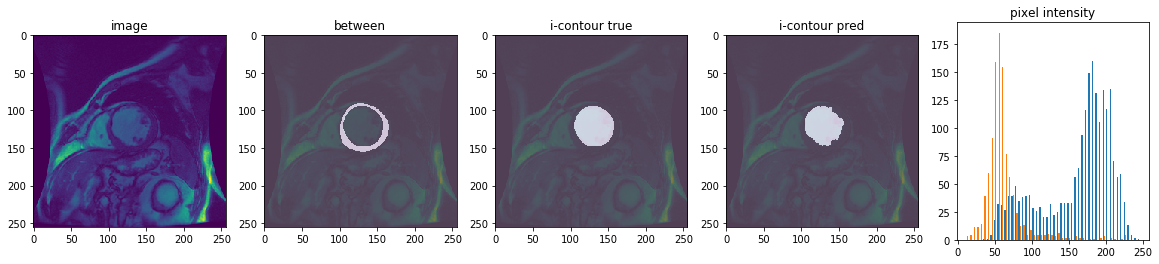

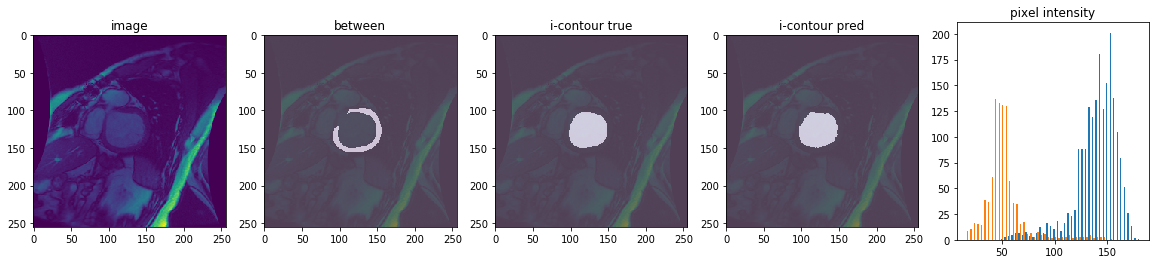

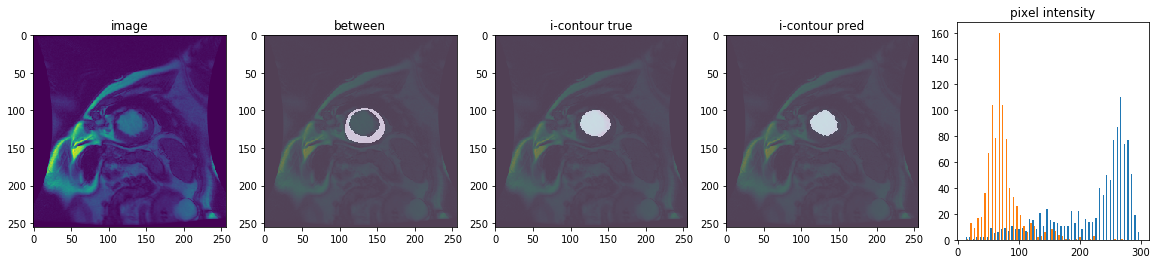

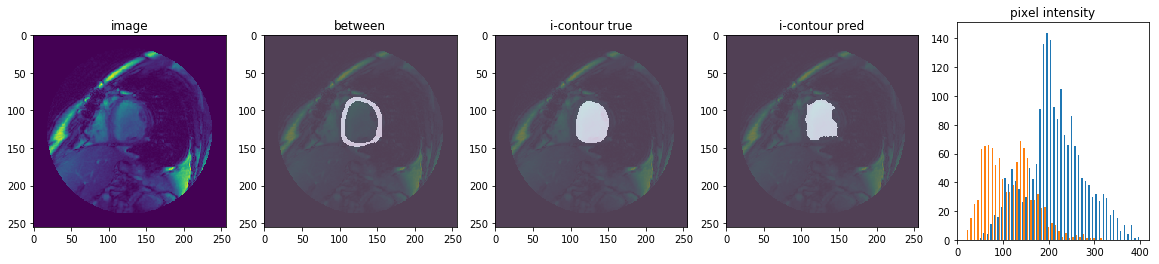

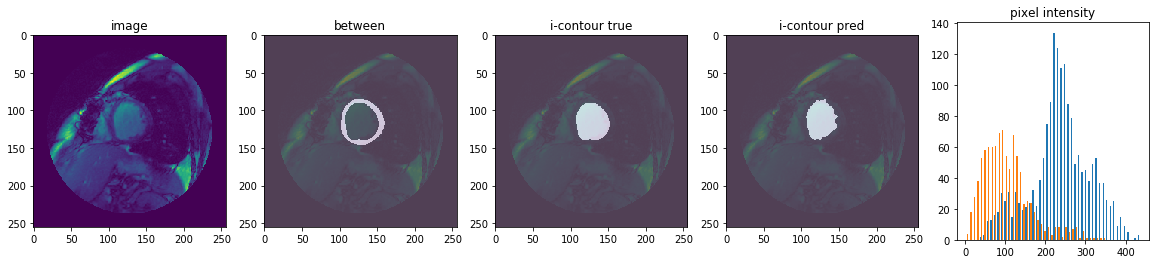

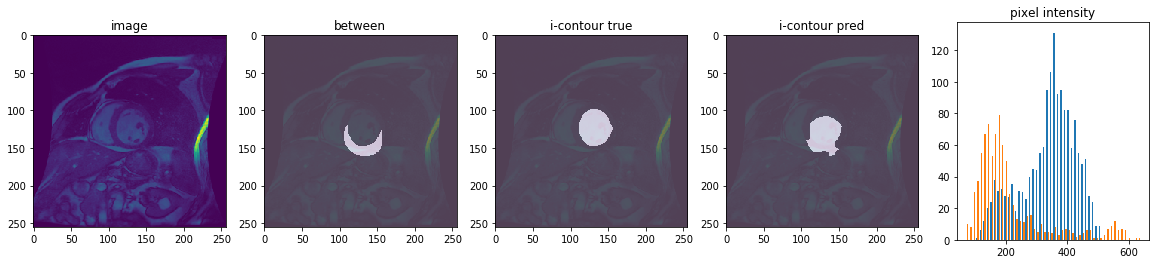

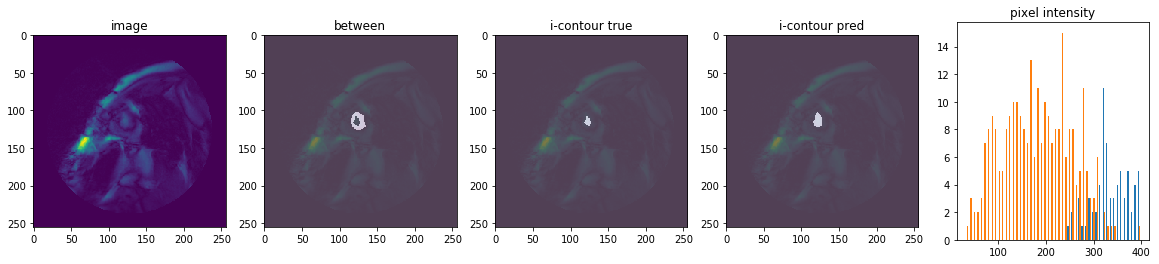

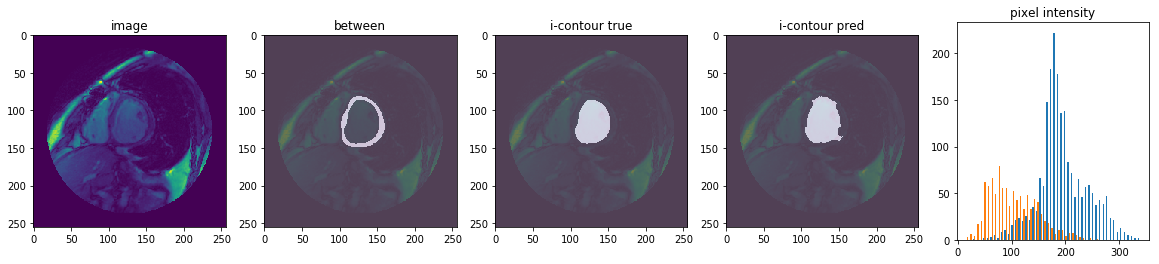

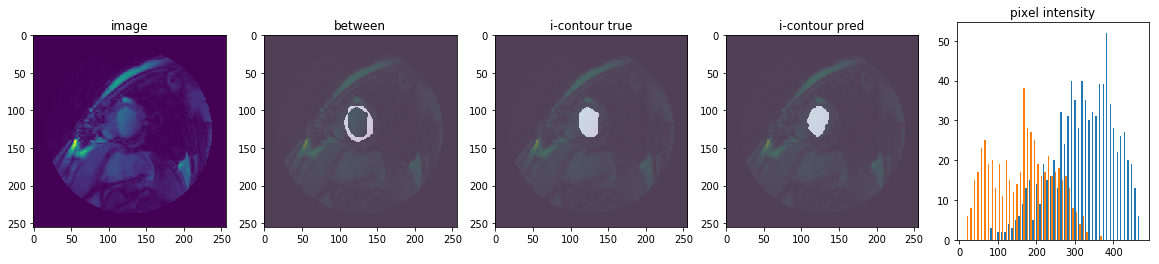

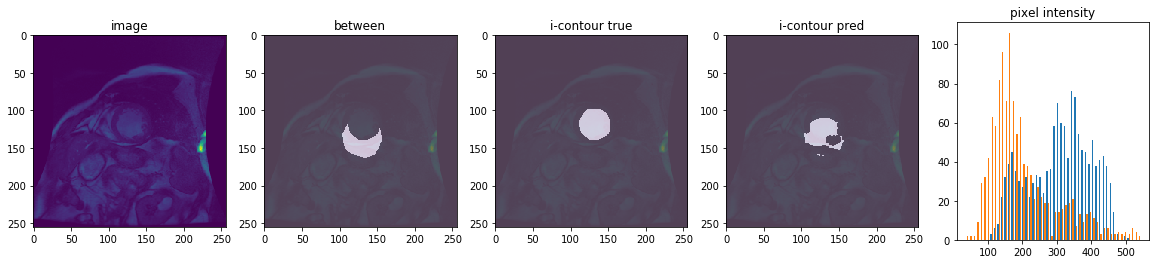

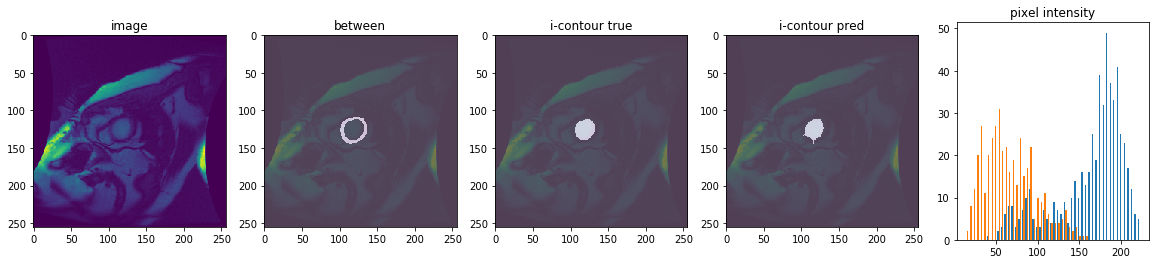

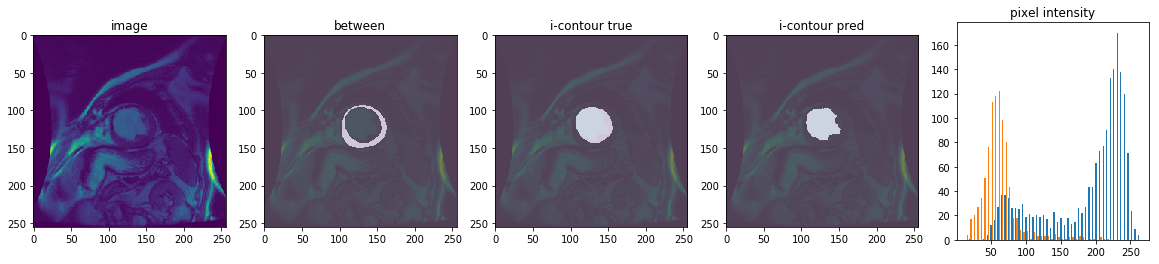

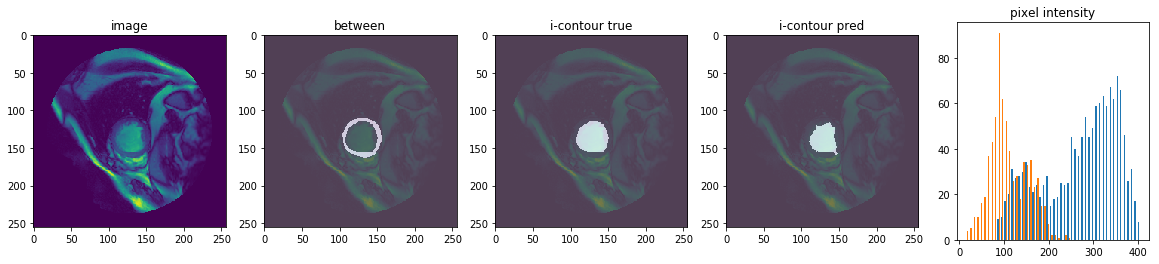

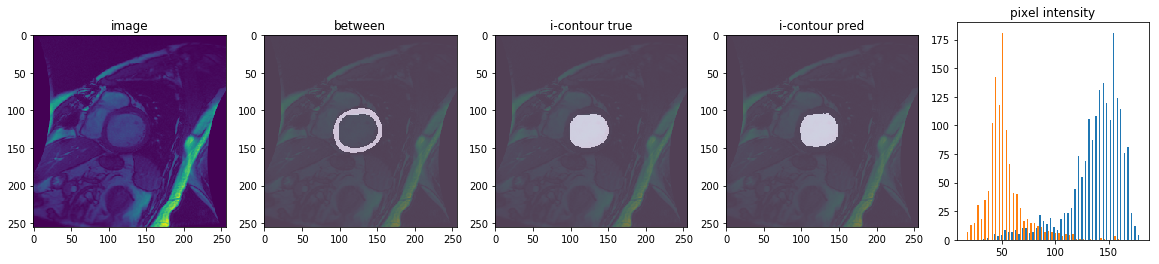

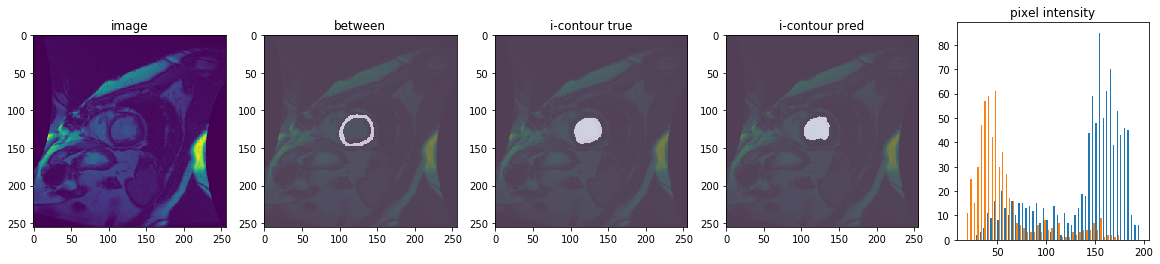

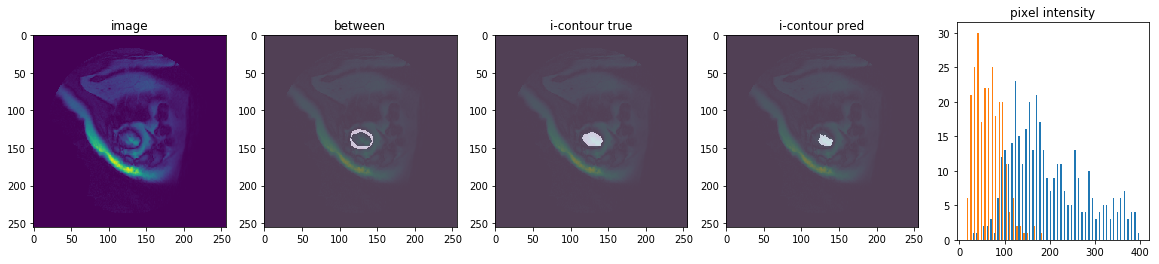

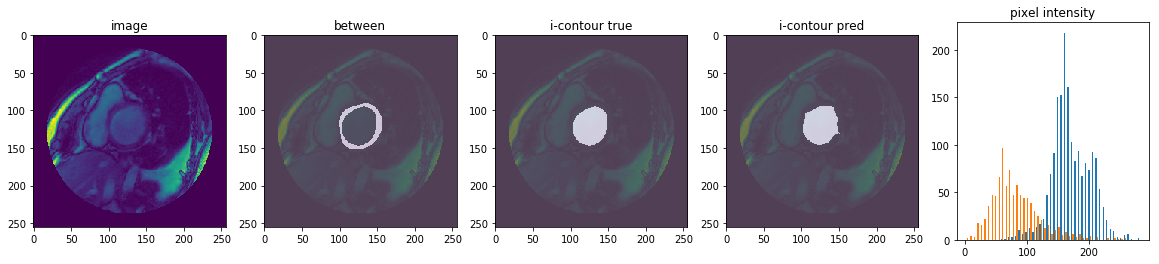

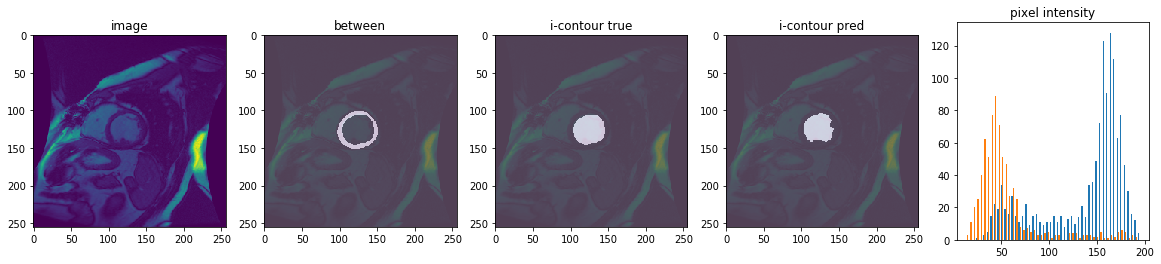

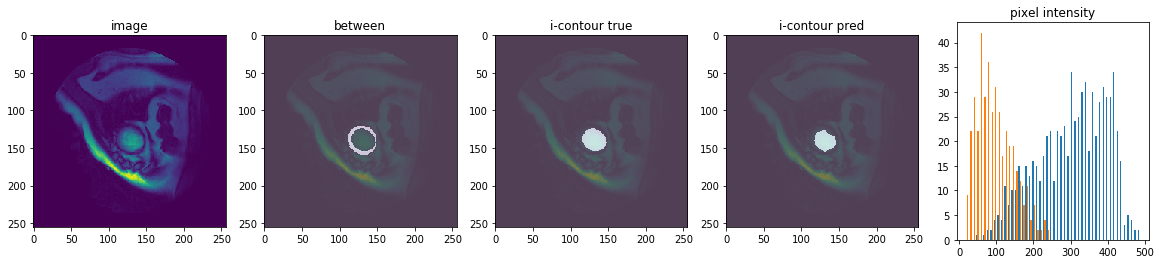

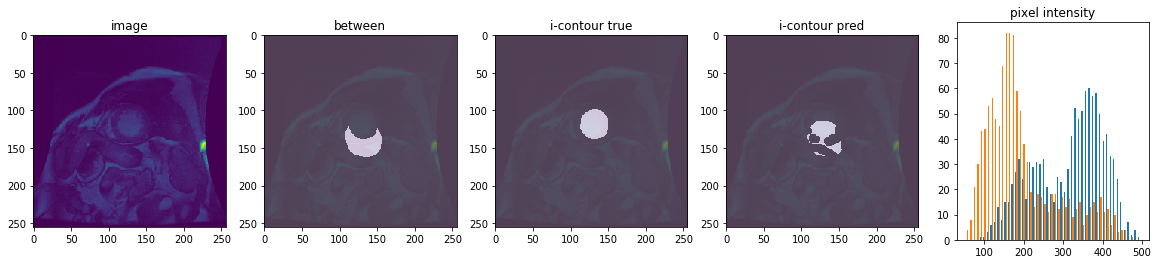

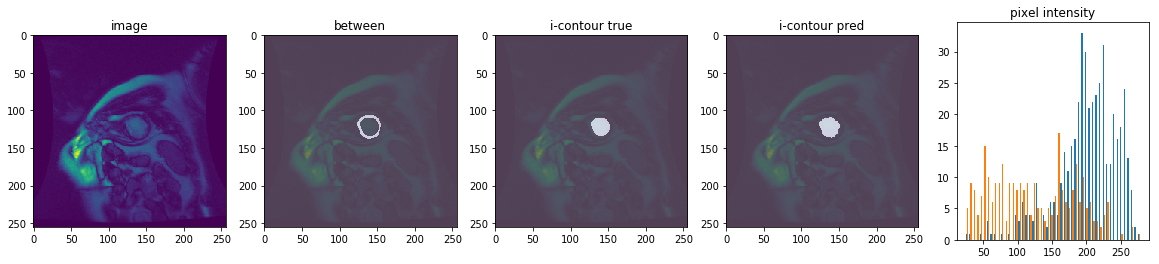

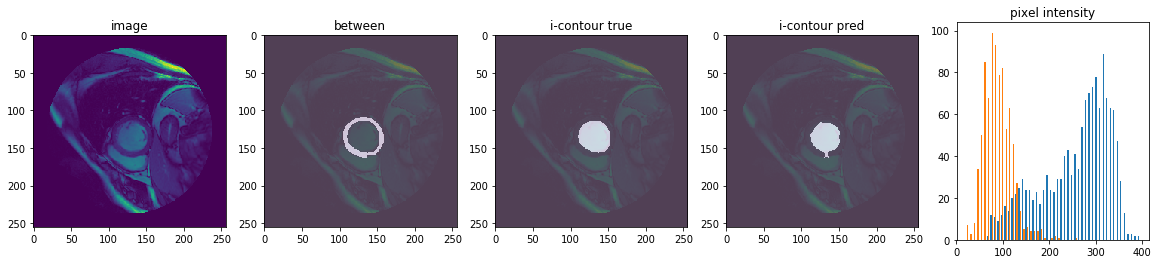

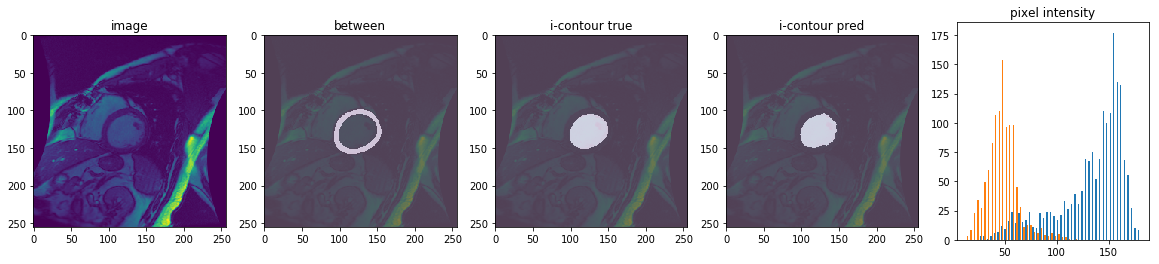

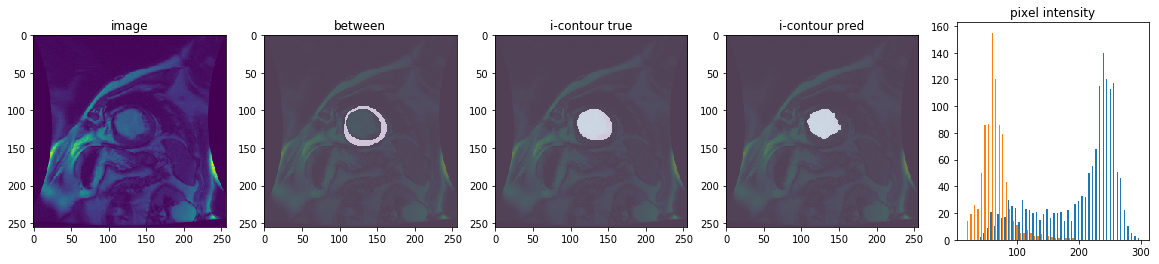

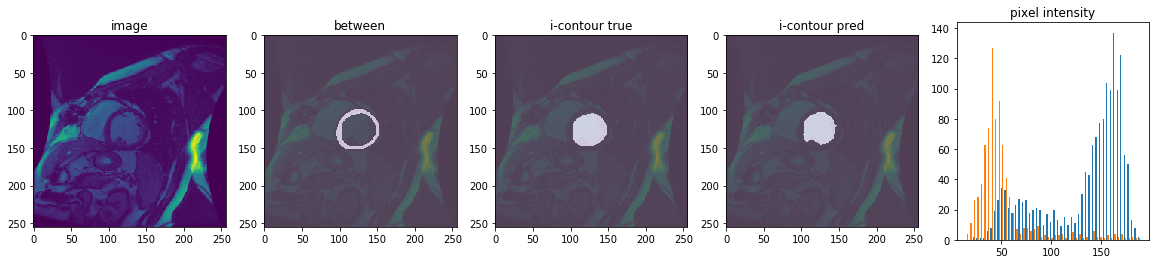

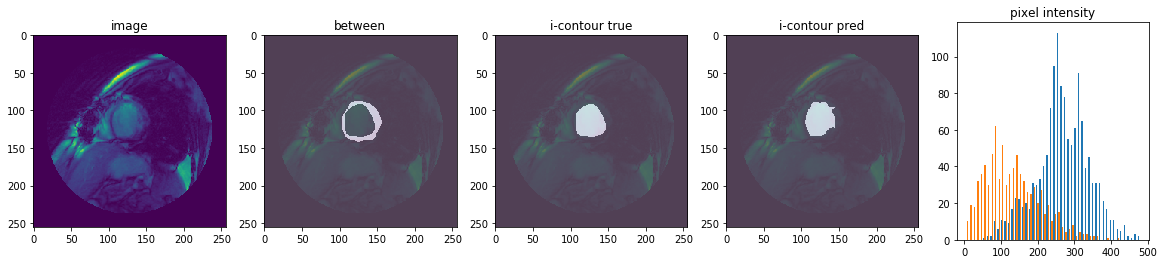

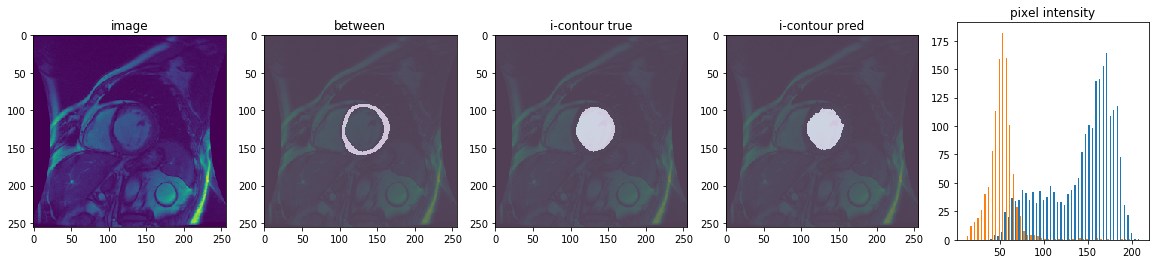

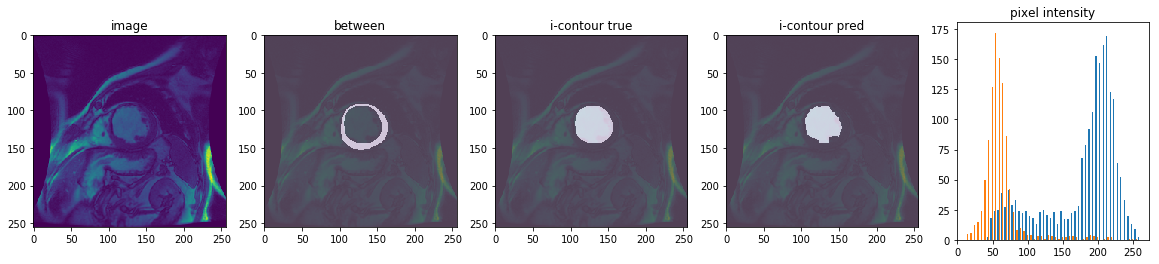

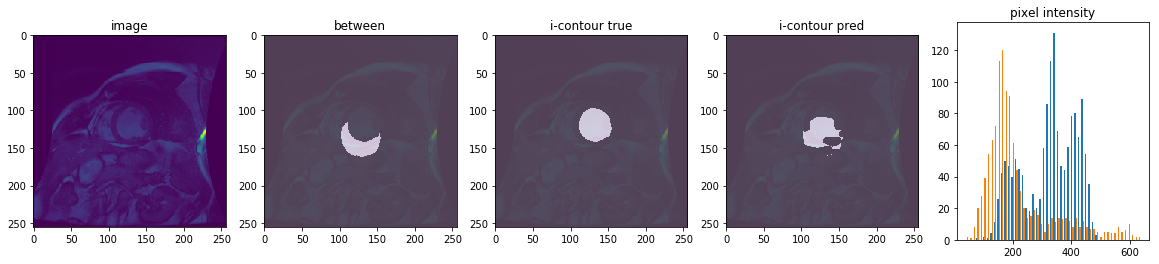

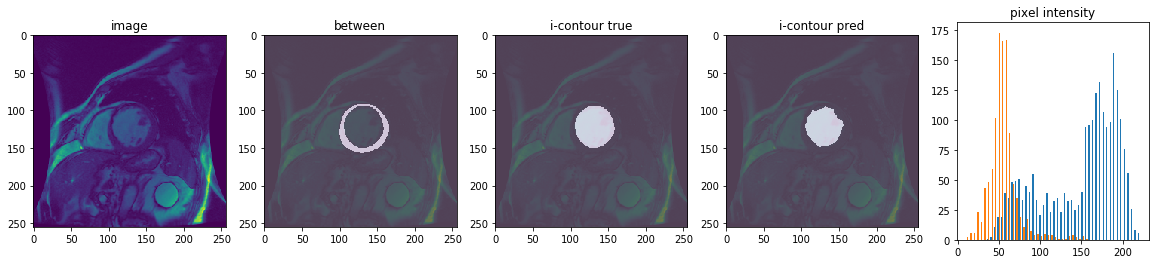

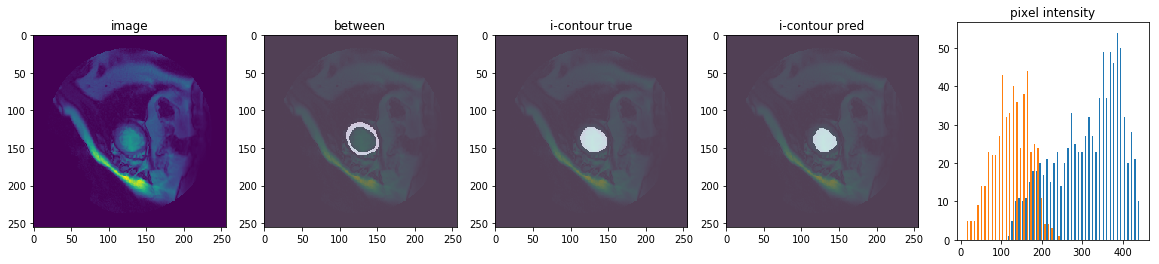

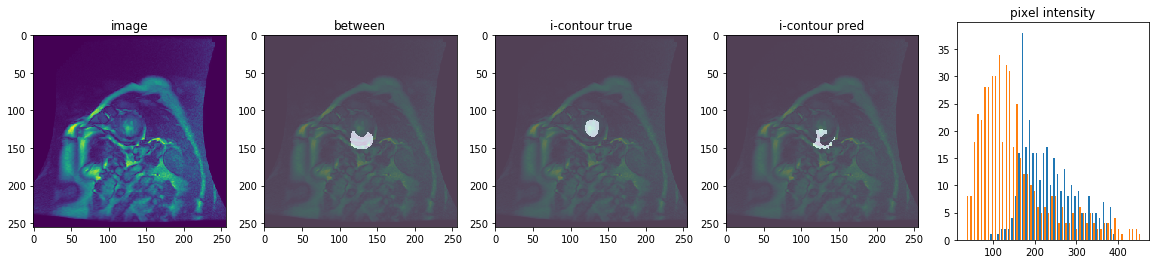

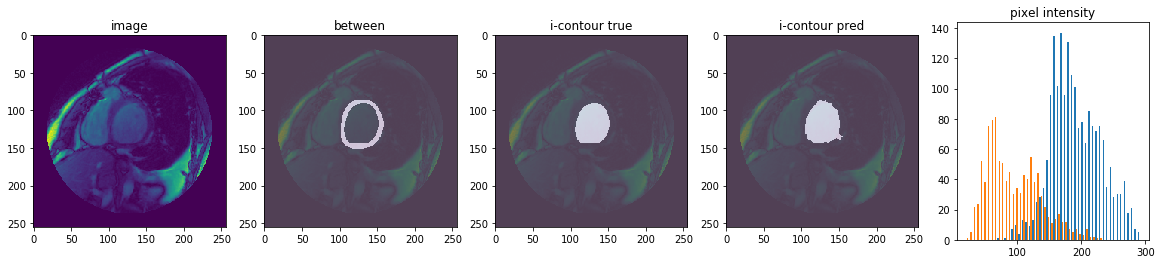

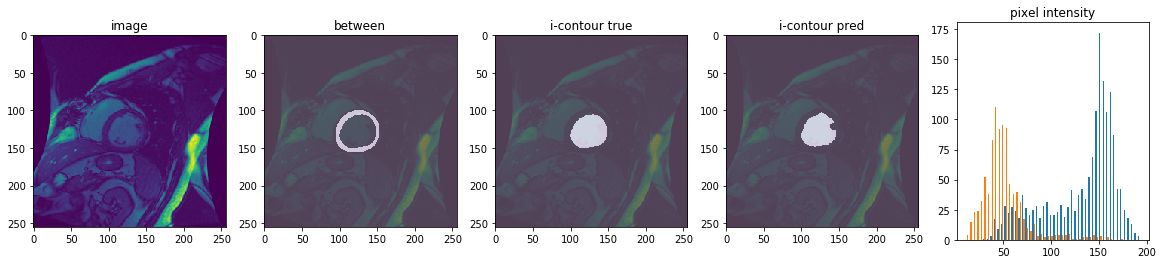

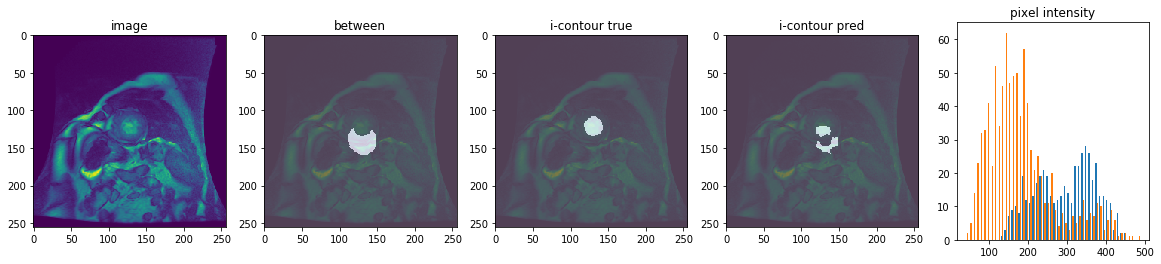

In [6]:
for i in range(images.shape[0]):
    fig = plt.figure(figsize=(20, 4))
    ax = fig.add_subplot(151)
    ax.imshow(images[i])
    ax.set_title('image')
    
    ax = fig.add_subplot(152)
    ax.imshow(images[i], alpha=0.5)
    ax.imshow(between[i], alpha=0.5, cmap='gray')
    ax.set_title('between')
    
    ax = fig.add_subplot(153)
    ax.imshow(images[i], alpha=0.5)
    ax.imshow(i_contours[i], alpha=0.5, cmap='gray')
    ax.set_title('i-contour true')
    
    ax = fig.add_subplot(154)
    ax.imshow(images[i], alpha=0.5)
    ax.imshow(i_contours_pred[i], alpha=0.5, cmap='gray')
    ax.set_title('i-contour pred')
    
    ax = fig.add_subplot(155)
    ax.hist([images[i][i_contours[i]], images[i][between[i]]], bins=50)
    ax.set_title('pixel intensity')
    
    plt.show()